In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=2.5)

import missingno as msno

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

우리가 해야할 프로세스는 다음과 같다.
1. 데이터셋 확인 - 대부분의 캐글 데이터들은 잘 정제되어 있지만 null data가 간혹 존재함. 이를 확인하고 향후 수정
2. 탐색적 데이터 분석(exploratory data analysis) - 여러 피쳐들을 개별적으로 분석하고 피쳐들간 상관관계를 확인한다. 여러 시각화 툴을 사용하여 insight를 얻음
3. feature engineering - 모델을 세우기에 앞서, 모델의 성능을 높일 수 있도록 feature들을 엔지니어링한다. 원핫인코딩, 클래스로 나누기, 구간으로 나누기, 텍스트 데이터 처리 등을 한다.
4. 모델 만들기 - sklearn을 사용해 모델을 만든다. 딥러닝을 위해 텐서플로우, 파이토치 등을 사용할 수도 있다.
5. 모델 학습 및 예측 - trainset을 가지고 모델을 학습시킨 후, 테스트 셋으로 예측한다.
6. 모델 평가 - 예측 성능이 원하는 수준인지 판단한다. 풀려는 문제에 따라 모델을 평가하는 방식도 달라진다.

## Dataset 확인
* pandas를 가장 많이 사용
* 판다스는 데이터셋의 간단한 통계적 분석부터 복잡한 처리들을 간단한 메소드를 사용하여 해낼 수 있다


In [4]:
df_train = pd.read_csv('/kaggle/input/titanic/train.csv')
df_test = pd.read_csv('/kaggle/input/titanic/test.csv')

In [5]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


우리가 다루는 문제에서 feature는 Pclass, Age, Sibsp, Parch, Fare이며, 예측하려는 target label은 survived이다

* survival : 생존여부. 타겟 라벨임. 1,0으로 표현됨
* Pclass : 티켓의 클래스. 1 = 1st, 2 = 2nd, 3 = 3rd 클래스로 나뉘며 categorical feature임
* sex : 성별. male, female로 나뉘며 binary
* Age : 나이. continuous
* sibSp : 함께 탑승한 형제와 배우자의 수. quantitative
* parch : 함께 탑승한 부모, 아이의 수. quantitative
* ticket : 티켓 번호. alphabet + integer
* fare : 탑승료. continuous
* cabin : 객실 번호. alphabet + integer
* embared : 탑승 항구. C = cherbourg, Q = queenstown, S = southampton


* pandas dataframe에는 `describe()` 메소드가 있는데, 이를 쓰면 각 feature가 가진 통계치들을 반환해줌

In [7]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
df_test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


* PassengerId 숫자와 다른, 즉 널 데이터가 존재하는 열(feature)가 있다.

### 1-1. Null data check

In [9]:
for col in df_train.columns:
    msg = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100*(df_train[col].isnull().sum() / df_train[col].shape[0]))
    print(msg)

column: PassengerId	 Percent of NaN value: 0.00%
column:   Survived	 Percent of NaN value: 0.00%
column:     Pclass	 Percent of NaN value: 0.00%
column:       Name	 Percent of NaN value: 0.00%
column:        Sex	 Percent of NaN value: 0.00%
column:        Age	 Percent of NaN value: 19.87%
column:      SibSp	 Percent of NaN value: 0.00%
column:      Parch	 Percent of NaN value: 0.00%
column:     Ticket	 Percent of NaN value: 0.00%
column:       Fare	 Percent of NaN value: 0.00%
column:      Cabin	 Percent of NaN value: 77.10%
column:   Embarked	 Percent of NaN value: 0.22%


In [10]:
for col in df_test.columns:
    msg = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100*(df_test[col].isnull().sum() / df_test[col].shape[0]))
    print(msg)

column: PassengerId	 Percent of NaN value: 0.00%
column:     Pclass	 Percent of NaN value: 0.00%
column:       Name	 Percent of NaN value: 0.00%
column:        Sex	 Percent of NaN value: 0.00%
column:        Age	 Percent of NaN value: 20.57%
column:      SibSp	 Percent of NaN value: 0.00%
column:      Parch	 Percent of NaN value: 0.00%
column:     Ticket	 Percent of NaN value: 0.00%
column:       Fare	 Percent of NaN value: 0.24%
column:      Cabin	 Percent of NaN value: 78.23%
column:   Embarked	 Percent of NaN value: 0.00%


* train, test set에서 age, cabin, embarked에 null data가 존재하는 것을 알 수 있음.
* MANO 라는 라이브러리를 사용하면 null data의 존재를 더 쉽게 볼 수 있음.

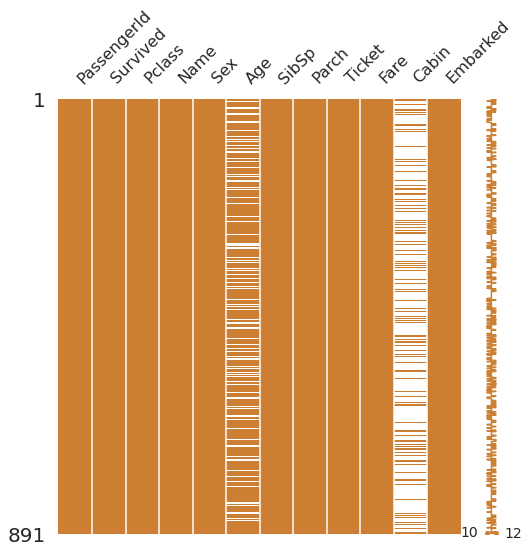

In [11]:
msno.matrix(df=df_train.iloc[:,:], figsize = (8,8), color = (0.8,0.5,0.2))

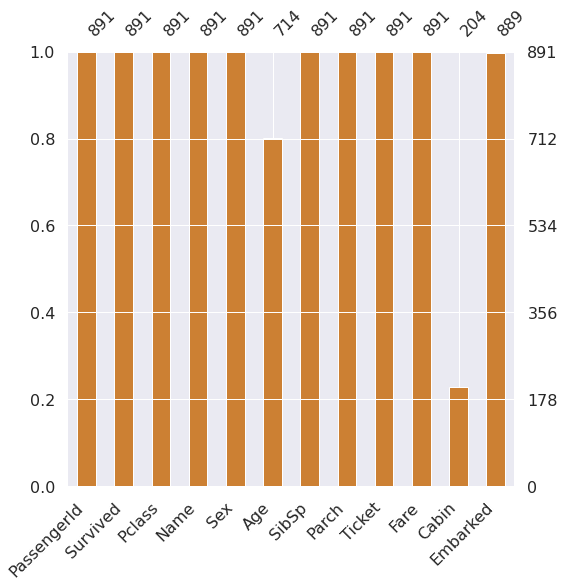

In [12]:
msno.bar(df=df_train.iloc[:, :], figsize=(8,8), color=(0.8,0.5,0.2))

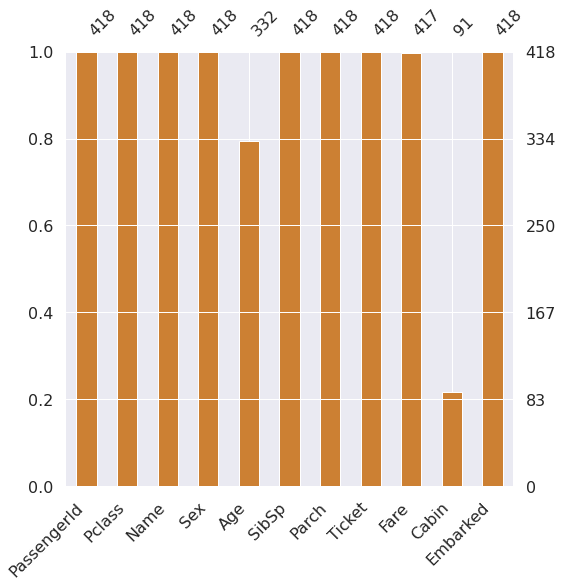

In [13]:
msno.bar(df=df_test.iloc[:, :], figsize=(8,8), color=(0.8,0.5,0.2))

### 1.2 Target label 확인

* target label이 어떤 distribution을 가지고 있는지 확인해봐야 함.
* 지금 같은 binary calssification 문제의 경우에서, 1과 0의 분포가 어떠냐에 따라 모델의 평가 방법이 달라질 수 있다.

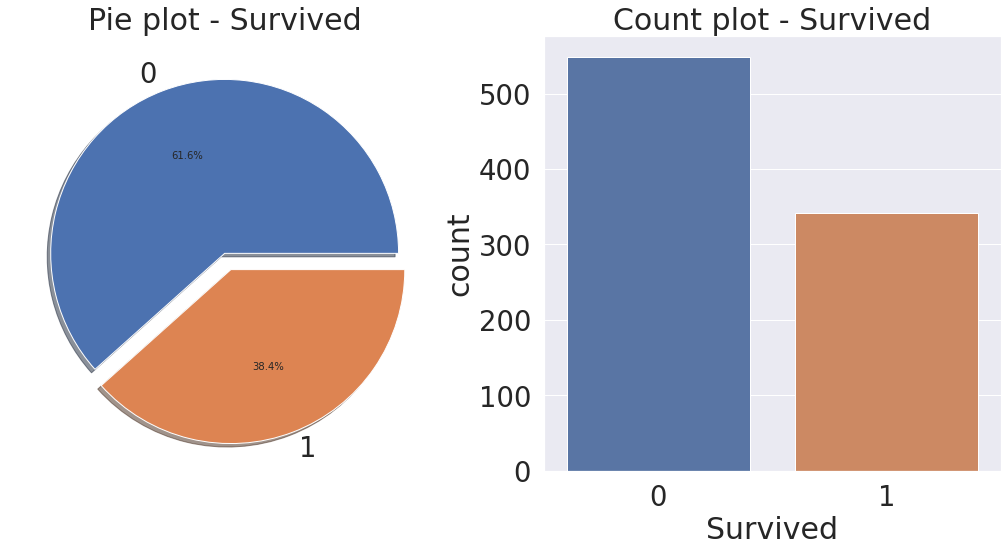

In [14]:
f, ax = plt.subplots(1,2, figsize=(18,8))

df_train['Survived'].value_counts().plot.pie(explode=[0,0.1], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Pie plot - Survived')
ax[0].set_ylabel('')
sns.countplot('Survived', data=df_train, ax=ax[1])
ax[1].set_title('Count plot - Survived')

plt.show()

* 38.4% 가 살아남았다.
* target label의 분포가 제법 균일(balanced)하다. 불균일한 경우, 예를 들어 100중 1이 99, 0이 1개인 경우에는 만약 모델이 모든것을 1이라해도 정확도가 99%가 나오게 됨. 0을 찾는 문제라면 이 모델은 원하는 결과를 줄 수 없게 된다. 지금 문제는 그렇지 않으니 계속 진행

# 2. Exploratory data analysis

* 이제 본격적으로 데이터 분석. 데이터는 매우 많음. 이 많은 데이터 안에 숨겨진 사실을 찾기 위해서는 적절한 시각화가 필요함
* 시각화 라이브러리는 matplotlib, seaborn, plotly 등이 있음. 특정 목적에 맞는 소스코드를 정리해두어 필요할 때마다 참고하면 편하다.

## 2.1 Pclass

* Pclass는 ordinal, 서수형 데이터이다. 카테고리이면서, 순서가 있는 데이터 타입이다.
* 먼저 Pclass에 따른 생존률의 차이를 살펴보겠다. 엑셀의 피벗 차트와 유사한 작업을 하게 되는데, pandas dataframe 에서는 `groupby`를 사용하면 쉽게 할 수 있다. 또한 `pivot` 이라는 메소드도 있다.
* 'Plcass', 'Survived'를 가져온 후, pclass로 묶는다. 그러고 나면 각 pclass마다 0,1이 count 되는데, 이를 평균내면 각 pclass 별 생존률이 나온다.
* 아래와 같이 `count()`를 하면, 각 class에 몇명이 있는지 확인할 수 있으며, `sum()`을 하면, 216 명중 생존한(survived=1) 사람의 총합을 주게 된다.


In [15]:
df_train[['Pclass','Survived']].groupby(['Pclass'], as_index=True).count()

,Survived
Pclass,
1,216
2,184
3,491


In [16]:
pd.crosstab(df_train['Pclass'], df_train['Survived'], margins=True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


* pandas의 crosstab을 사용하면 좀 더 위 과정을 좀 더 수월하게 볼 수 있습니다.
* grouped 객체에 `mean()`을 하게 되면, 각 클래스별 생존률을 얻을 수 있습니다. class 1이면 아래와 같다.

`80/(80+136) = 0.63`

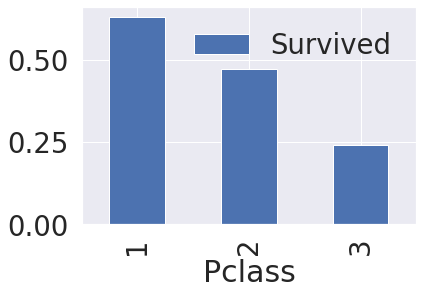

In [17]:
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).mean().sort_values(by='Survived', ascending=False).plot.bar()

* Pclass가 좋을 수록(1st) 생존률이 높은 것을 확인할 수 있다.
* seaborn의 countplot을 이용하여, 특정 label에 따른 개수를 확인해볼 수 있음.

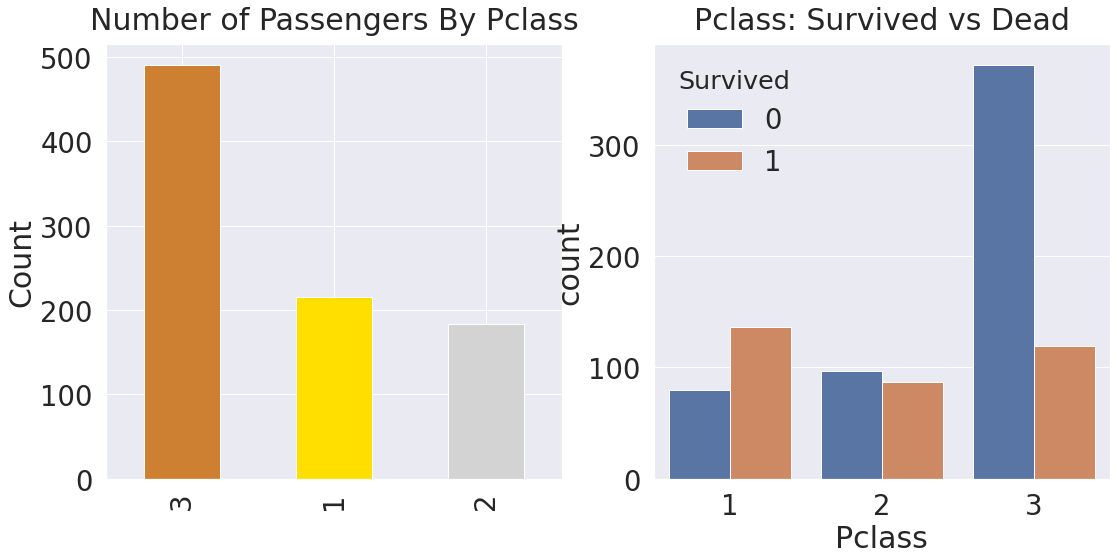

In [19]:
y_position = 1.02
f, ax = plt.subplots(1,2, figsize=(18,8))
df_train['Pclass'].value_counts().plot.bar(color=['#CD7F32','#FFDF00','#D3D3D3'], ax=ax[0])
ax[0].set_title('Number of Passengers By Pclass', y=y_position)
ax[0].set_ylabel('Count')
sns.countplot('Pclass', hue='Survived', data=df_train, ax=ax[1])
ax[1].set_title('Pclass: Survived vs Dead', y=y_position)
plt.show()

* 클래스가 높을 수록, 생존 확률이 높은 걸 확인할 수 있다. Pclass 1,2,3 순서대로 63%, 48%, 25% 이다.
* 생존에 Pclass가 큰 영향을 미친다고 생각해볼 수 있으며, 나중에 모델을 세울 때 이 feature를 사용하는 것이 좋을 것이라 판단 가능함.

## 2.2 Sex

* 성별로 생존률이 어떻게 달라지는지 확인
* pandas groupby와 seaborn countplot을 사용해서 시각화함.

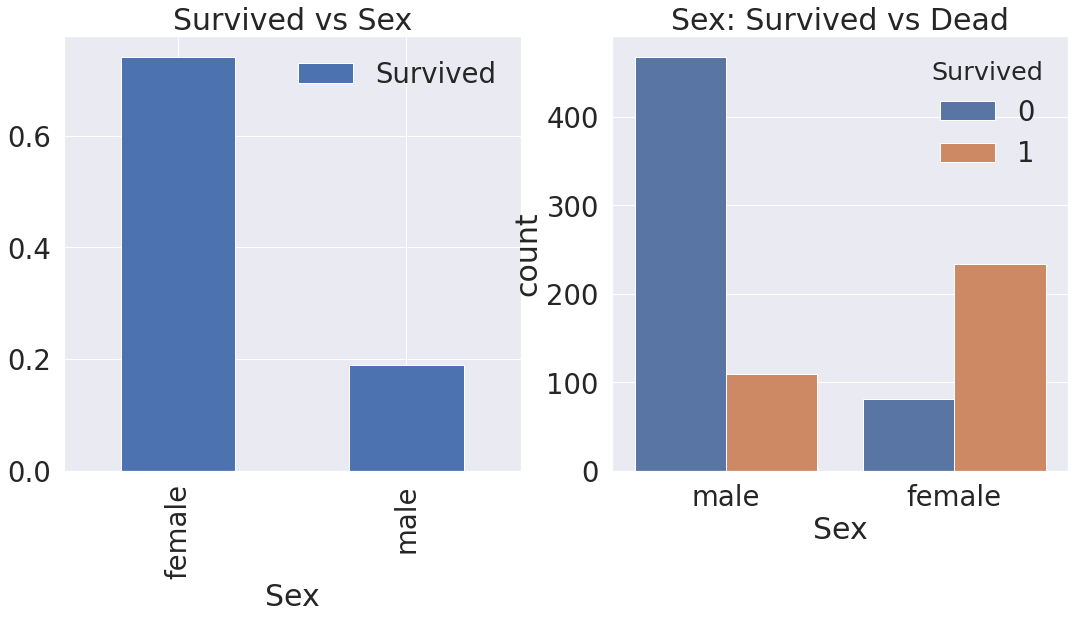

In [20]:
f, ax = plt.subplots(1,2, figsize=(18,8))
df_train[['Sex', 'Survived']].groupby(['Sex'], as_index=True).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survived vs Sex')
sns.countplot('Sex', hue='Survived', data=df_train, ax=ax[1])
ax[1].set_title('Sex: Survived vs Dead')
plt.show()

In [21]:
df_train[['Sex','Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [22]:
pd.crosstab(df_train['Sex'], df_train['Survived'], margins=True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Sex,,,
female,81,233,314
male,468,109,577
All,549,342,891


* Pclass와 마찬가지로, Sex도 예측 모델에 쓰일 중요한 feature임을 알 수 있다.

## 2.3 Both Sex and Pclass

* 이번에는 Sex, Pclass 두 가지에 관하여 생존에 어떻게 달아지는지 확인
* seaborn의 factorplot을 이용하면, 손 쉽게 3개의 차원으로 이루어진 그래프를 그릴 수 있다.

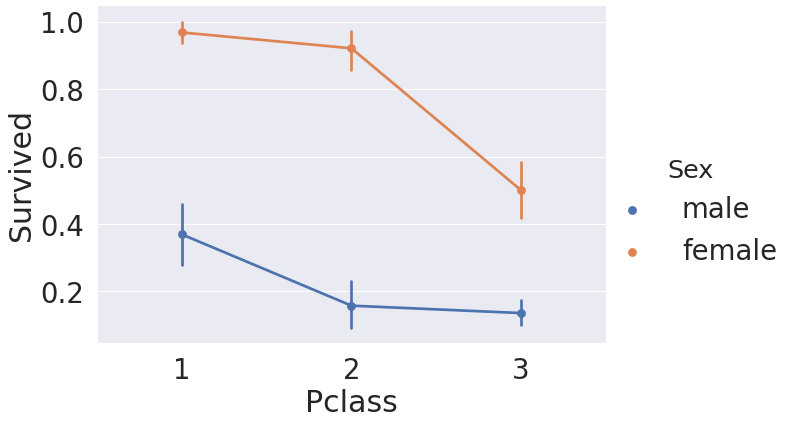

In [23]:
sns.factorplot('Pclass', 'Survived', hue='Sex', data=df_train, size=6, aspect=1.5)

* 모든 클래스에서 female이 살 확률이 male보다 더 높다.
* 남자, 여자 상관없이 클래스가 높을 수록 살 확률이 높음
* 위 그래프는 hue 대신 column으로 하면 아래와 같음.

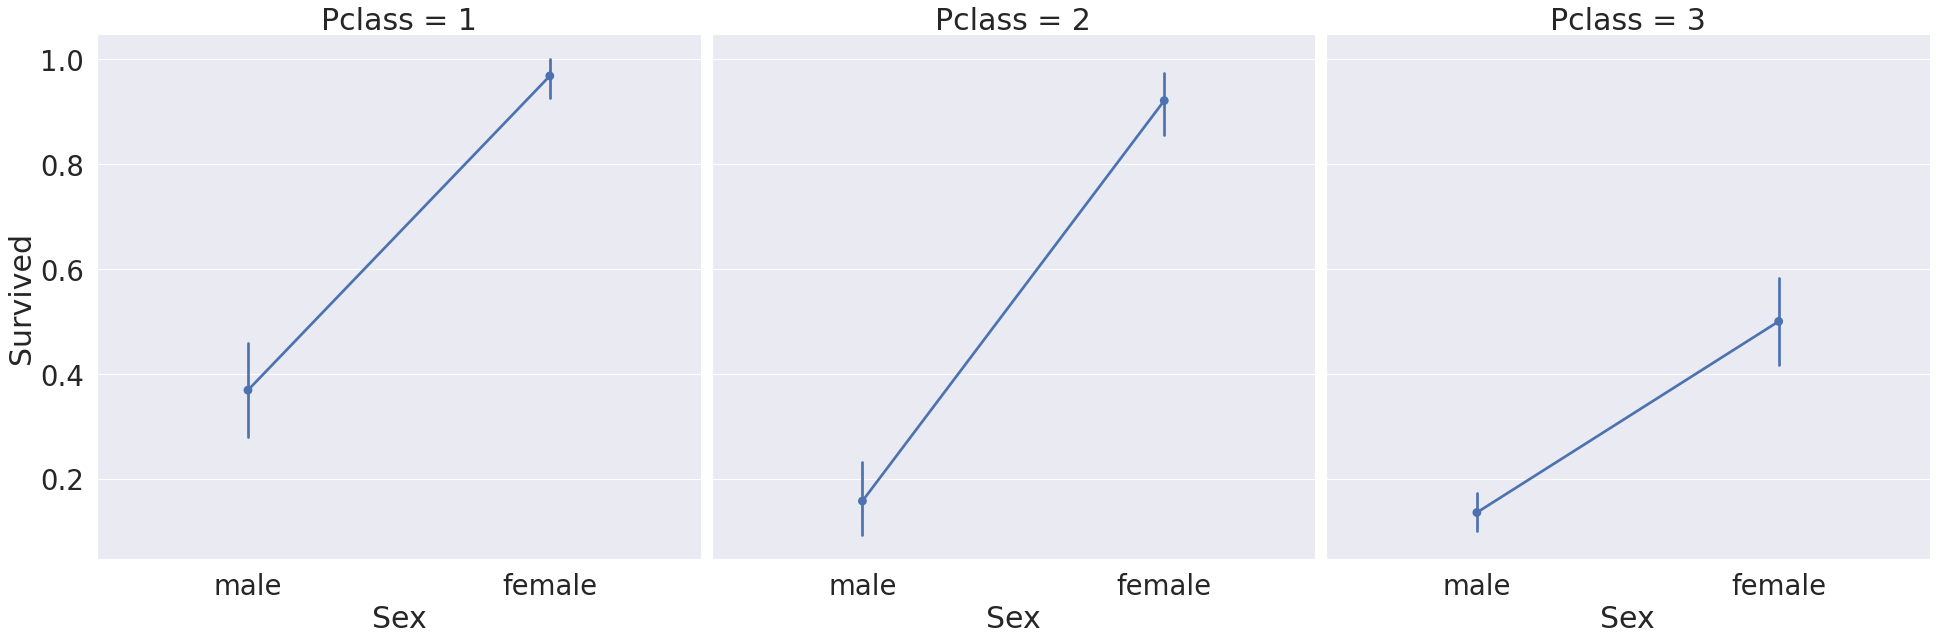

In [24]:
sns.factorplot(x='Sex', y='Survived', col='Pclass', data=df_train, satureation=.5, size=9, aspect=1)

## 2.4 Age


In [25]:
print('제일 나이 많은 탑승객 : {:.1f} Years'.format(df_train['Age'].max()))
print('제일 나이 적은 탑승객 : {:.1f} Years'.format(df_train['Age'].min()))
print('탑승객 평균 나이 : {:.1f} Years'.format(df_train['Age'].mean()))


제일 나이 많은 탑승객 : 80.0 Years
제일 나이 적은 탑승객 : 0.4 Years
탑승객 평균 나이 : 29.7 Years


* 생존에 따른 Age의 histogram

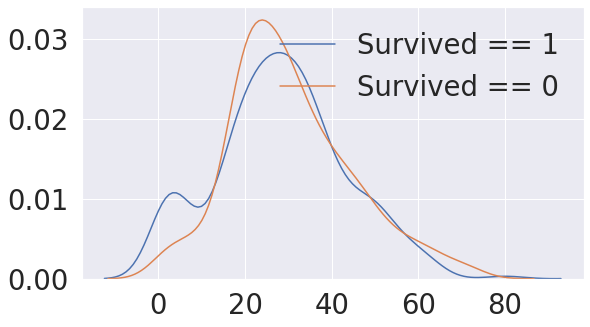

In [26]:
fig, ax = plt.subplots(1,1,figsize=(9,5))
sns.kdeplot(df_train[df_train['Survived']==1]['Age'], ax=ax)
sns.kdeplot(df_train[df_train['Survived']==0]['Age'], ax=ax)
plt.legend(['Survived == 1', 'Survived == 0'])
plt.show()

* 생존자 중 나이가 어린 경우가 많음.

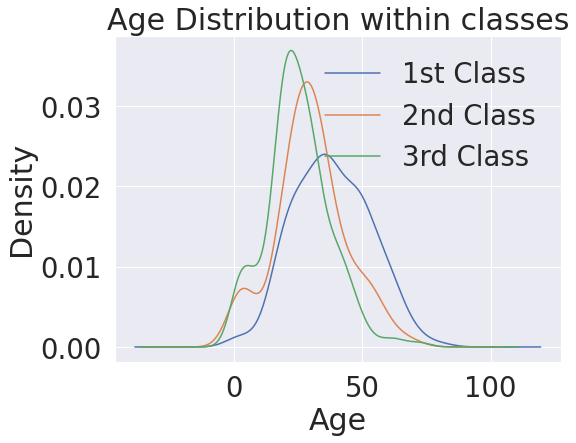

In [27]:
plt.figure(figsize=(8,6))
df_train['Age'][df_train['Pclass']==1].plot(kind='kde')
df_train['Age'][df_train['Pclass']==2].plot(kind='kde')
df_train['Age'][df_train['Pclass']==3].plot(kind='kde')

plt.xlabel('Age')
plt.title('Age Distribution within classes')
plt.legend(['1st Class', '2nd Class', '3rd Class'])

* Class가 높을 수록 나이 많은 사람의 비중이 커짐
* 나이대가 변하면서 생존률이 어떻게 되는지 
* 나이범위를 점점 넓혀가며, 생존률이 어떻게 되는지

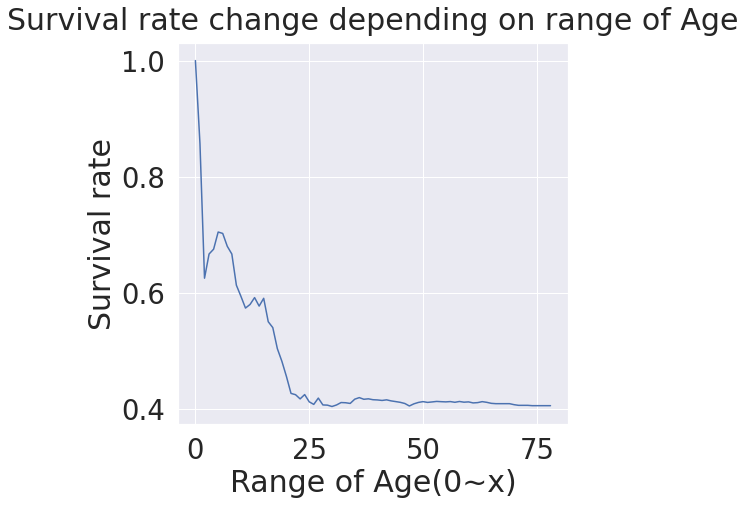

In [28]:
cummulate_survival_ratio = []
for i in range(1,80):
    cummulate_survival_ratio.append(df_train[df_train['Age'] < i ]['Survived'].sum() / len(df_train[df_train['Age'] < i]['Survived']))
    
plt.figure(figsize=(7,7))
plt.plot(cummulate_survival_ratio)
plt.title('Survival rate change depending on range of Age', y=1.02)
plt.ylabel('Survival rate')
plt.xlabel('Range of Age(0~x)')
plt.show()

* 나이가 어릴 수록 생존률이 확실히 높다.
* 이 나이가 중요한 feature로 쓰일 수 있음.

## 2.5 Pclass, Sex, Age

* Sex, Pclass, Age, Survived. seaborn의 violinplot
* x축은 우리가 나눠서 보고싶어하는 case(여기선 Pclass, Sex)를 나타내고, y축은 보고 싶어하는 distribution(Age) 입니다.

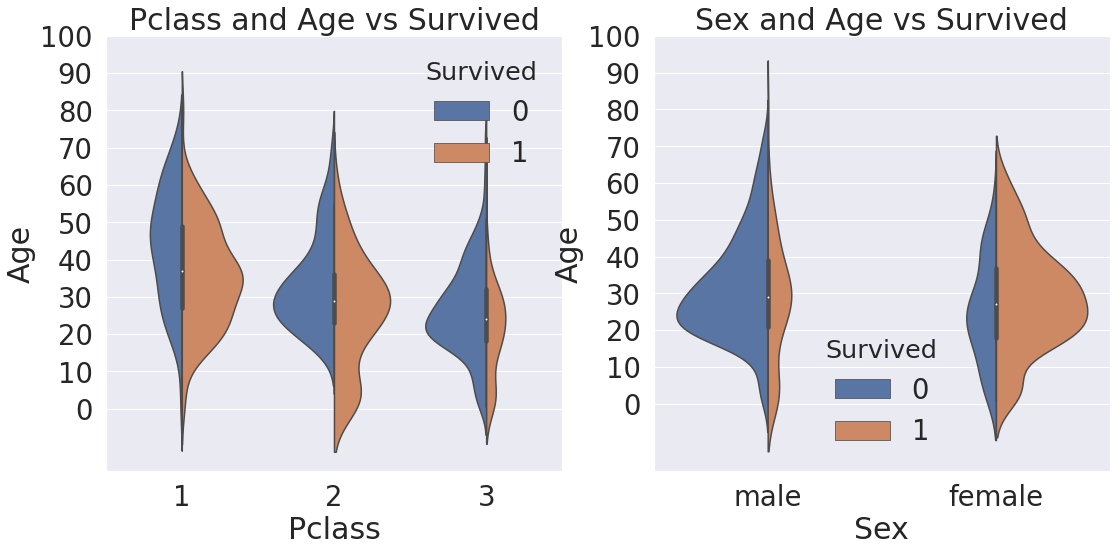

In [30]:
f,ax = plt.subplots(1,2, figsize=(18,8))
sns.violinplot('Pclass', 'Age', hue='Survived', data=df_train, scale='count', split=True, ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0,110,10))
sns.violinplot('Sex','Age',hue='Survived', data=df_train, scale='count', split=True, ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0,110,10))
plt.show()

* (왼쪽) Pclass 별로 Age의 distribution이 어떻게 다른지, 거기에 생존여부에 따라 구분한 그래프
* (오른쪽) Sex 별로 distribution이 어떻게 다른지 보여주는 그래프
* 생존만 봤을 때, 모든 클래스에서 나이가 어릴 수록 생존을 많이 한 것을 볼 수 있습니다.
* 명확히 여자가 생존을 많이 한 것을 볼 수 있음.
* 여성과 아이를 먼저 챙긴 것!

## 2.6 Embarked

* Embarked는 탑승한 항구를 나타냄

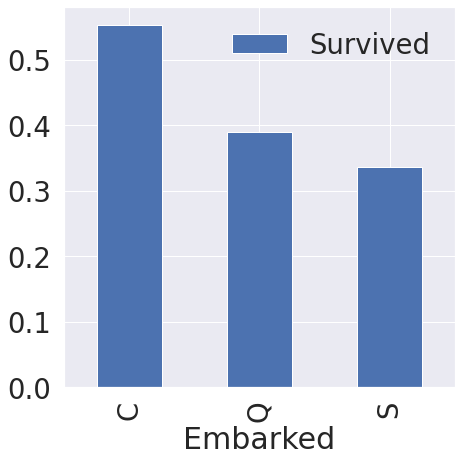

In [31]:
f, ax = plt.subplots(1,1, figsize=(7,7))
df_train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=True).mean().sort_values(by='Survived', ascending=False).plot.bar(ax=ax)

* 조금의 차이는 있지만 생존률은 좀 비슷하다. C가 제일 높다
* 모델에 얼마나 큰 영향을 미칠지는 모르겠지만, 사용하겠다.
* 모델을 만들고 나면 우리가 사용한 feature들이 얼마나 중요한 역할을 했는지 확인할 수 있다.
* 다른 feature로 split 하여 한번 살펴보자

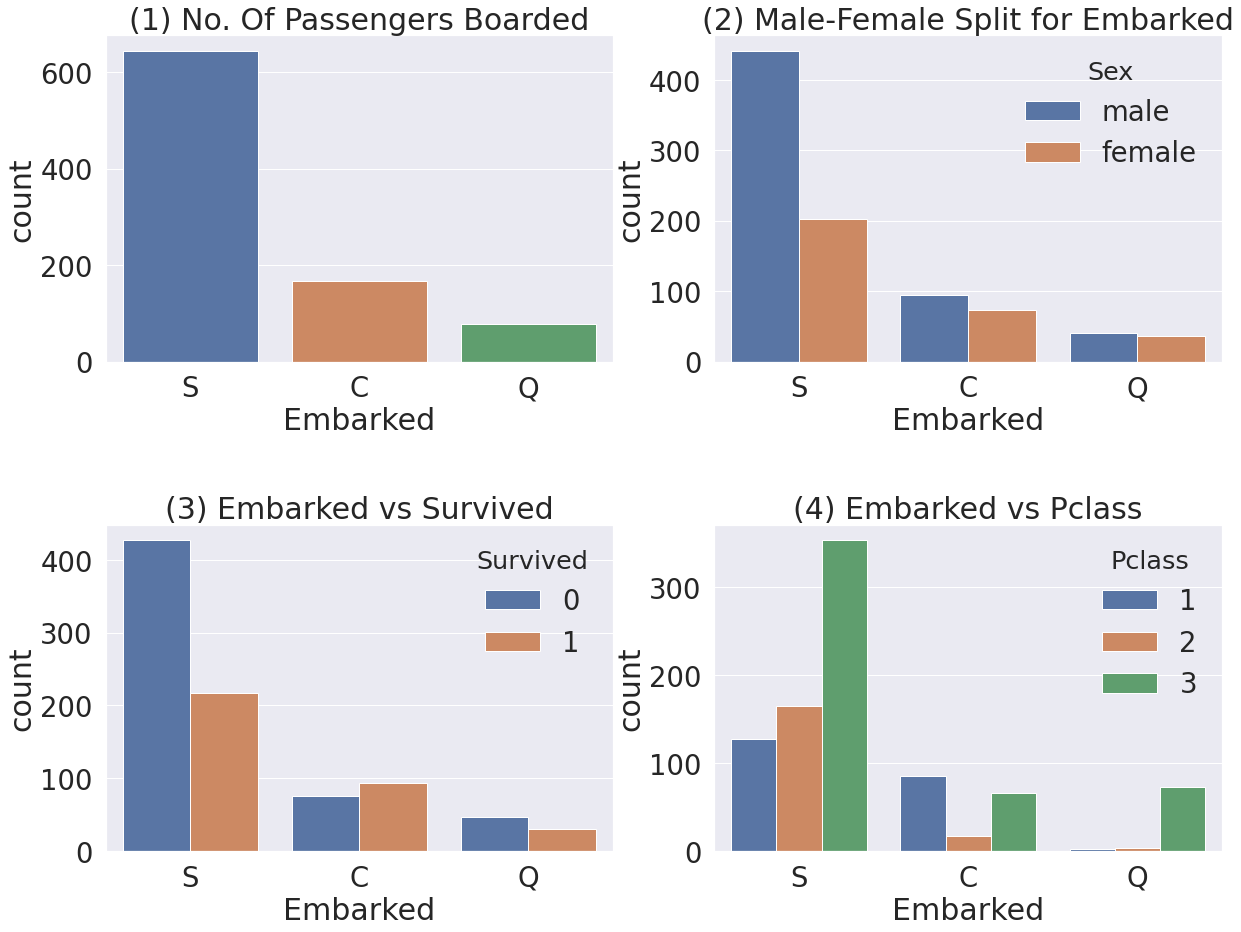

In [33]:
f, ax= plt.subplots(2,2, figsize=(20,15))
sns.countplot('Embarked', data=df_train, ax=ax[0,0])
ax[0,0].set_title('(1) No. Of Passengers Boarded')
sns.countplot('Embarked', hue='Sex', data=df_train, ax=ax[0,1])
ax[0,1].set_title('(2) Male-Female Split for Embarked')
sns.countplot('Embarked', hue='Survived', data=df_train, ax=ax[1,0])
ax[1,0].set_title('(3) Embarked vs Survived')
sns.countplot('Embarked', hue = 'Pclass', data=df_train, ax=ax[1,1])
ax[1,1].set_title('(4) Embarked vs Pclass')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

* Figure(1) - 전체적으로 봤을 때, S에서 가장 많은 사람이 탑승했다.
* Figure(2) - C와 Q는 남녀의 비율이 비슷하고, S는 남자가 더 많다.
* Figure(3) - 생존확률이 S인 경우 많이 낮은 걸 볼 수 있다.
* Figure(4) - Class로 split해서 보니, C가 생존확률이 높은 건 클래스가 높은 사람이 많이 타서 그렇다! S는 3rd class가 많아서 생존확률이 낮게 나옴.

## 2.7 Family - SibSp(형제 자매) + Parch(부모, 자녀)

* SibSp + Parch = Family가 될 것

In [34]:
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1 # 자신을 포함해야 하니 1을 더한다
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch']

In [35]:
print("Maximum size of Family", df_train['FamilySize'].max())
print("Minimum size of Family", df_train['FamilySize'].min())

Maximum size of Family 11
Minimum size of Family 1


* FamilySize와 생존의 관계


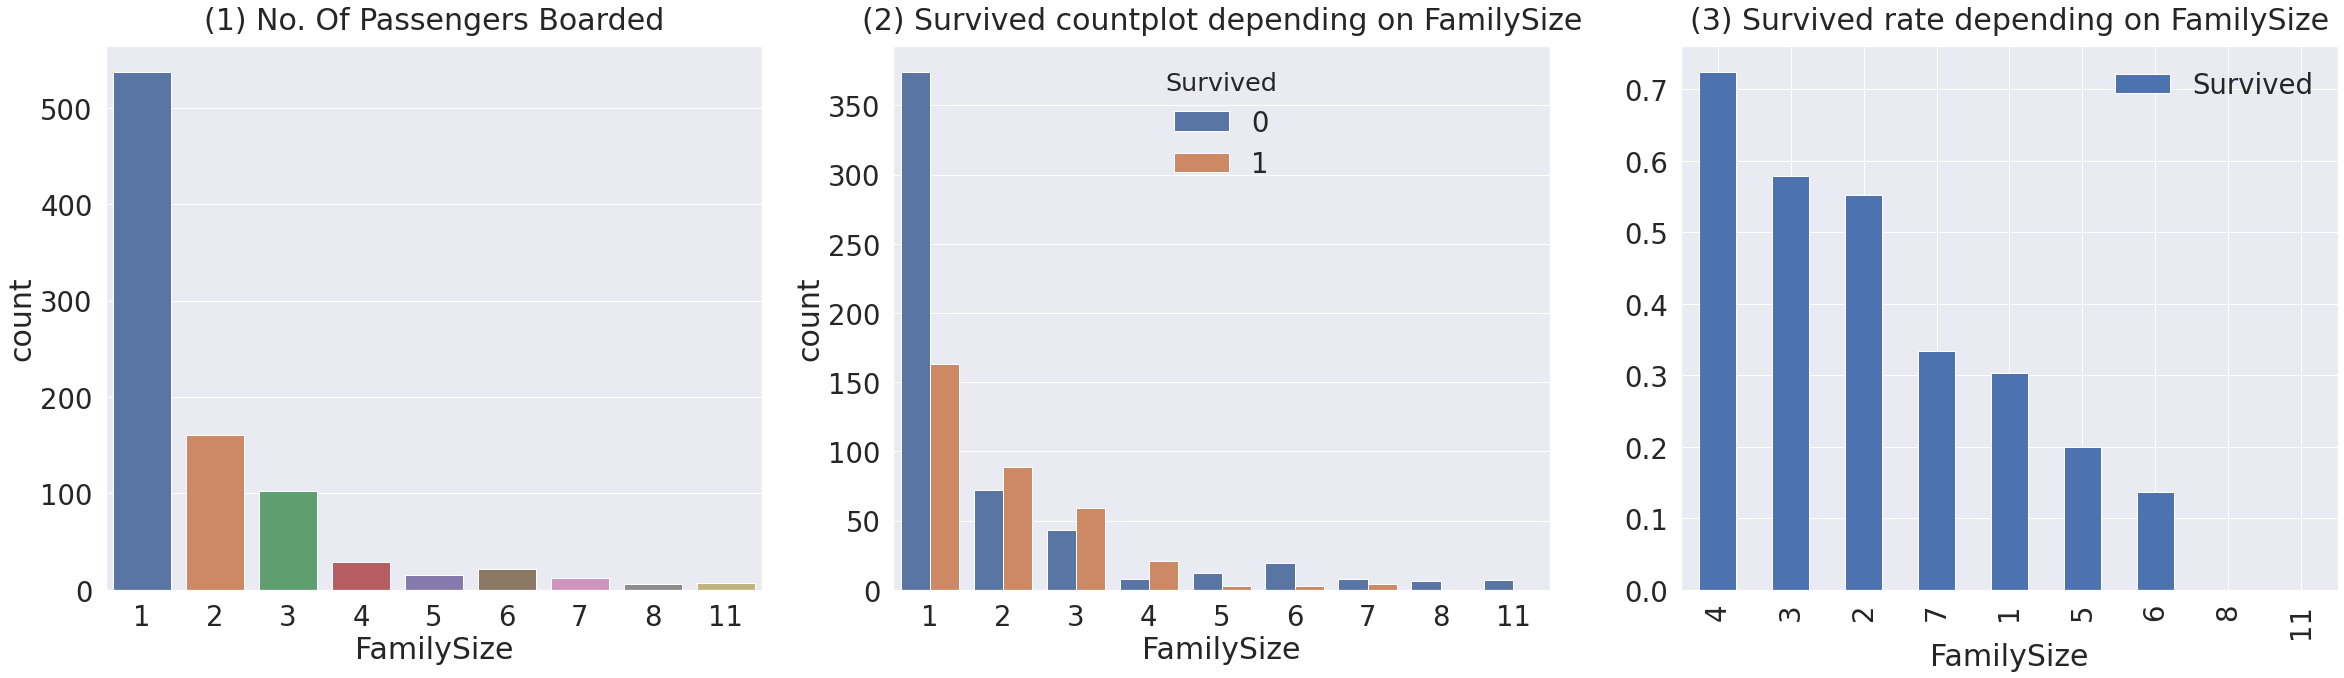

In [37]:
f, ax = plt.subplots(1,3, figsize=(40,10))
sns.countplot('FamilySize', data=df_train, ax=ax[0])
ax[0].set_title('(1) No. Of Passengers Boarded', y=1.02)

sns.countplot('FamilySize', hue='Survived', data=df_train, ax=ax[1])
ax[1].set_title('(2) Survived countplot depending on FamilySize', y=1.02)

# df_train[['FamilySize', 'Survived']].groupby(['FamiltSize'], as_index=True).mean().sort_values(by='Survived', ascending=False).plot.bar(ax=ax[2])
df_train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=True).mean().sort_values(by='Survived', ascending=False).plot.bar(ax=ax[2])
ax[2].set_title('(3) Survived rate depending on FamilySize', y=1.02)

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

* Figure (1) - 가족크기가 1~11까지 있음을 볼 수 있음. 대부분 1명이고 그 다음으로 2,3,4명이다.
* Figure (2), (3) - 가족 크기에 따른 생존 비교임. 가족이 4명인 경우가 가장 생존확률이 높습니다. 가족수가 많아질수록, (5,6,7,8,11) 생존확률이 낮아짐. 가족수가 너무 작아도(1), 너무 커도(5,6,7,8,11) 생존확률이 작음.
* 3~4명 선에서 생존확률이 높은 걸 확인할 수 있음.

## 2.8 Fare

* Fare는 탑승 요금이며, continous feature임

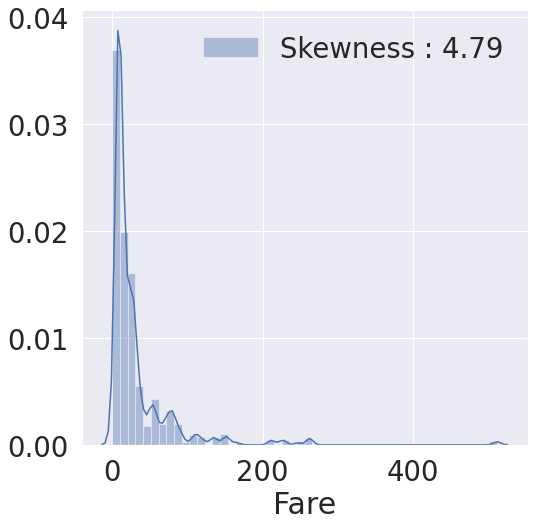

In [38]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
g = sns.distplot(df_train['Fare'], color='b', label='Skewness : {:.2f}'.format(df_train['Fare'].skew()), ax=ax)
g = g.legend(loc='best')

* distribution이 매우 비대칭인 것을 알 수 있음. (high skewness). 
* 만약 이대로 모델에 넣어준다면 자칫 모델이 잘못 학습할 수도 있다. 몇 개 없는 outlier에 대해서 너무 민감하게 반응한다면 실제 예측 시에 좋지 못한 결과를 부를 수 있다.
* outlier의 영향을 줄이기 위해 Fare에 log 취한다.
* pandas. dataFrame의 특정 columns에 공통된 작업(함수)를 적용하고 싶으면 아래의 map, 또는 apply를 사용하면 매우 손쉽게 적용
* fare columns의 데이터 모두를 log값 취하는 것. 파이썬의 간단한 lambda 함수를 이용해 간단한 로그를 적용하는 함수를 map에 인수로 넣어주면, Fare columns 데이터에 그대로 적용!

In [39]:
df_test.loc[df_test.Fare.isnull(), 'Fare'] = df_test['Fare'].mean()

df_train['Fare'] = df_train['Fare'].map(lambda i: np.log(i) if i>0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda i: np.log(i) if i>0 else 0)

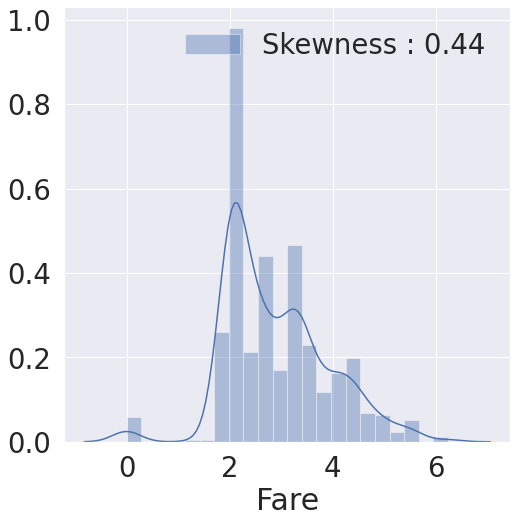

In [40]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
g=sns.distplot(df_train['Fare'], color='b', label='Skewness : {:.2f}'.format(df_train['Fare'].skew()), ax=ax)
g = g.legend(loc='best')

* log를 취하니, 이제 비대칭성이 많이 사라졌다!
* 사실 방금한 것은 feature engineering에 들어가는 부분이다.
* 모델을 학습시키는 위해, 그리고 그 모델의 성능을 높이기 위해 feature 들에 여러 조작을 가하거나, 새로운 feature를 추가하는 것을 feature engineering이라고 한다

## 2.9 Cabin

* 이 feature는 NaN이 대략 80%이므로, 생존에 영향을 미칠 중요한 정보를 얻어내기 힘들다
* 그러므로 모델에 포함시키지 않겠다.

In [41]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,1.981001,NaN,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,4.266662,C85,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,2.070022,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,3.972177,C123,S,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,2.085672,NaN,S,1


## 2.10 Ticket

* 이 feature는 NaN은 없음. 
* string data이므로 우리가 작업을 해줘야 실제 모델에 적용할 수 있다.

In [42]:
df_train['Ticket'].value_counts()

CA. 2343      7
1601          7
347082        7
CA 2144       6
347088        6
             ..
250646        1
350047        1
2695          1
2669          1
F.C. 12750    1
Name: Ticket, Length: 681, dtype: int64

# 3. Feature engineering

* 가장 먼저, dataset에 존재하는 null data를 채운다
* 아무 숫자로 채울 수는 없고, null data를 포함하는 Feature의 statistics를 참고하거나 다른 아이디어를 짜내어 채울 수 있다
* null data를 어떻게 채우느냐에 따라 모델의 성능이 좌지우지될 수 있기 때문에 신경써야 함
* Feature enginerring은 실제 모델의 학습에 쓰려고 하는 것이므로, train 뿐만 아니라 test도 똑같이 적용해줘야 한다!!!


## 3.1 Fill Null
### 3.1.1 Fill Null in Age using title

* Age 에는 null data가 177개 있음. 이를 채울 수 있는 여러 아이디가 있겠지만, title + statistics를 사용할 것임.
* 영어에서는 Miss, Mrr, Mrs 같은 title이 존재함. 각 탑승객의 이름에는 꼭 이런 title이 들어가는데 이를 사용할 것
* pandas series 에는 data를 string으로 바꿔주는 str method, 거기에 정규표현식ㅇ르 적용하게 햊는 extract method가 있음. 이를 사용하여 title을 쉽게 추출할 수 있다.

In [72]:
df_train['Initial']= df_train.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations
    
df_test['Initial']= df_test.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations

* pandas의 crosstab을 이용하여 추출한 Initial과 Sex 간의 count를 살펴봄

In [73]:
pd.crosstab(df_train['Initial'], df_train['Sex']).T.style.background_gradient(cmap='summer_r')

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


* 위의 테이블을 참고하여, 남자 여자가 쓰는 initial을 구분한다.
* replace 메소드를 사용하면 특정 데이터 값을 원하는 값으로 치환해줌.

In [74]:
df_train['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

df_test['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

In [75]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


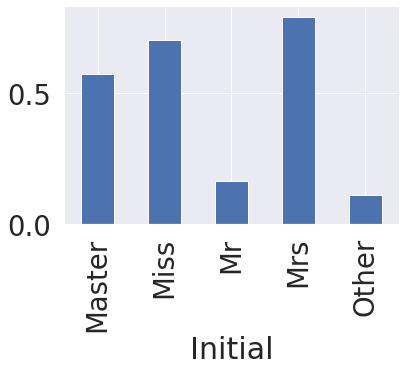

In [76]:
df_train.groupby('Initial')['Survived'].mean().plot.bar()

* 본격적으로 Null 채우기.
* null data를 채우는 방법은 많이 존재함. statistics를 활용하는 방법도 있고, null data가 없는 데이터를 기반으로 새로운 머신러닝 알고리즘을 만들어 예측해서 채워넣는 방법도 있다. 여기에서는 statistics
* 여기서 statistics 는 train data의 것을 의미한다. 언제나 test를 unseen으로 둔 상태로 놔둬야 하며, train에서 얻은 statistics를 기반으로 test의 null data를 채워줘야 함.


In [77]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


* Age의 평균을 이용해 Null value를 채우겠다.
* pandas dataframe을 다룰 때는 boolean array를 이용해 indexing 하는 방법이 편리함
* 아래 코드의 첫줄을 해석하자면, isnull()이면서 Initial이 Mr 인 조건을 만족하는 row(탑승객)의 'Age'를 33으로 치환한다는 뜻
* loc + boolean + column을 사용해 값을 치환하는 방법은 자주 쓰이므로 꼭 익숙해지자.

In [78]:
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mr'), 'Age']= 33
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mrs'),'Age'] = 36
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Master'),'Age'] = 5
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Miss'),'Age'] = 22
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Other'),'Age'] = 46

df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mr'),'Age'] = 33
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mrs'),'Age'] = 36
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Master'),'Age'] = 5
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Miss'),'Age'] = 22
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Other'),'Age'] = 46

* 여기선 간단하게 null을 채웠지만, 좀 더 다양한 방법을 쓴 예시들이 존재함
* https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling


### 3.1.2 Fill Null in Embarked

In [79]:
print('Embarked has ', sum(df_train['Embarked'].isnull()), ' Null values')

Embarked has  2  Null values


* Embarked는 Null value가 2개이고, S에서 가장 많은 탑승객이 있었으므로, 간단하게 Null을 S로 채운다
* dataframe의 fillna method를 이용하면 쉽게 채울 수 있다. 
* inplace = True로 하면 df_train에 fillna를 실제로 적용하게 된다.

In [80]:
df_train['Embarked'].fillna('S', inplace=True)

## 3.2 Change Age(continuous to categorical)

* Age는 현재 continuous feature. 이대로 모델을 세울 수 있지만, Age를 몇 개의 그룹으로 나누어 카테고리화시킬 수 있음.
* continuous 를 categorical로 바꾸면 자칫 information loss 가 생길 수 있음!

* 방법은 여러가지가 있음. dataframe의 indexing 방법인 loc을 상사용하여 직접해줄 수 있고, apply를 사용해 함수를 넣어줄 수도 있음.
* 첫 번째는 loc을 사용한 방법. 10살 간격으로 나누겠다

In [81]:
df_train['Age_cat'] = 0
df_train.loc[df_train['Age'] < 10, 'Age_cat'] = 0
df_train.loc[(10 <= df_train['Age']) & (df_train['Age'] < 20), 'Age_cat'] = 1
df_train.loc[(20 <= df_train['Age']) & (df_train['Age'] < 30), 'Age_cat'] = 2
df_train.loc[(30 <= df_train['Age']) & (df_train['Age'] < 40), 'Age_cat'] = 3
df_train.loc[(40 <= df_train['Age']) & (df_train['Age'] < 50), 'Age_cat'] = 4
df_train.loc[(50 <= df_train['Age']) & (df_train['Age'] < 60), 'Age_cat'] = 5
df_train.loc[(60 <= df_train['Age']) & (df_train['Age'] < 70), 'Age_cat'] = 6
df_train.loc[70 <= df_train['Age'], 'Age_cat'] = 7

df_test['Age_cat'] = 0
df_test.loc[df_test['Age'] < 10, 'Age_cat'] = 0
df_test.loc[(10 <= df_test['Age']) & (df_test['Age'] < 20), 'Age_cat'] = 1
df_test.loc[(20 <= df_test['Age']) & (df_test['Age'] < 30), 'Age_cat'] = 2
df_test.loc[(30 <= df_test['Age']) & (df_test['Age'] < 40), 'Age_cat'] = 3
df_test.loc[(40 <= df_test['Age']) & (df_test['Age'] < 50), 'Age_cat'] = 4
df_test.loc[(50 <= df_test['Age']) & (df_test['Age'] < 60), 'Age_cat'] = 5
df_test.loc[(60 <= df_test['Age']) & (df_test['Age'] < 70), 'Age_cat'] = 6
df_test.loc[70 <= df_test['Age'], 'Age_cat'] = 7

* 두번째는 간단한 함수를 만들어 apply 메소드에 넣어주는 방법
* 훨씬 수월함

In [82]:
def category_age(x):
    if x < 10:
        return 0
    elif x < 20:
        return 1
    elif x < 30:
        return 2
    elif x < 40:
        return 3
    elif x < 50:
        return 4
    elif x < 60:
        return 5
    elif x < 70:
        return 6
    else:
        return 7    
    
df_train['Age_cat_2'] = df_train['Age'].apply(category_age)

* 두 가지 방법이 잘 적용됐다면, 둘 다 같은 결과를 내야 함.
* 이를 확인하기 위해 Series 간 boolean 비교 후 all() 메소드를 사용한다. `all()` 메소드는 모든 값이 True면 True, 하나라도 False가 있으면 False를 줌

In [83]:
print('1번 방법, 2번 방법 둘다 같은 결과를 내면 True 줘야함 -> ', (df_train['Age_cat'] == df_train['Age_cat_2']).all())

1번 방법, 2번 방법 둘다 같은 결과를 내면 True 줘야함 ->  True


* 중복되는 Age_cat 칼럼과 원래 칼럼 Age를 제거

In [84]:
df_train.drop(['Age', 'Age_cat_2'], axis = 1, inplace=True)
df_test.drop(['Age'], axis=1, inplace=True)

## 3.3 Change Initial, Embarked and Sex (string to numerical)

* 현재 Initial은 Mr, Mrs, Miss, Master, Other 총 5개로 이루어져 있음. 이런 카테고리로 표현되어져 있는 데이터를 모델에 인풋으로 넣어줄 때 우리가 해야할 것은 수치화
* map method를 가지고 간단히 가능
* 사전 순서대로 정리하여 mapping

In [85]:
df_train['Initial'] = df_train['Initial'].map({'Master':0, 'Miss':1, 'Mr':2, 'Mrs':3, 'Other':4})
df_test['Initial'] = df_test['Initial'].map({'Master':0, 'Miss':1, 'Mr':2, 'Mrs':3, 'Other':4})

* Embarked도 C,Q,S로 이루어져 있음. 이도 map을 이용해 바꾸자
* 그러기 앞서서, 특정 column에 어떤 값들이 있는지 확인해보는 방법을 잠깐 살펴본다.
* 간단히 `unique()` 메소드를 쓰거나 `value_counts()`를 써서 count까지 보는 방법이 있음

In [86]:
df_train['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [87]:
df_train['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

In [88]:
df_train['Embarked'] = df_train['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})
df_test['Embarked'] = df_test['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

* Null이 사라졌는지 확인해보자. Embarked Column만 가져온 것은 하나의 pandas Series의 객체이므로, `isnull()` 메소드를 사용해 Series의 값들이 null인지 아닌지에 대한 boolean값을 얻을 수 있다.
* 이것에 `any()`를 사용하여 True가 단 하나라도 있을 시(Null이 하나라도 있을 시) True를 반환해주게 됨
* 우리는 Null을 다 S로 바꾸었으므로 False를 얻게 됨

In [90]:
df_train['Embarked'].isnull().any()

False

* Sex도 Female, male로 이루어져 있음. map을 이용해 바꾸자

In [ ]:
df_train['Sex'] = df_train['Sex'].map({'female':0, 'male':1})
df_test['Sex'] = df_test['Sex'].map({'female':0, 'male':1})